In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
from sklearn.tree import DecisionTreeRegressor



## Loading the Project Root and start of cleaning
Filtering out the dataset the entries of 2014 till 2017. All in London.

In [85]:
# # Load the Kaggle dataset
# file_path = './Price_paid_records.csv'  # Update with your dataset path
# data = pd.read_csv(file_path)

# # Convert 'Date of Transfer' to datetime for filtering
# data['Date of Transfer'] = pd.to_datetime(data['Date of Transfer'], errors='coerce')

# # Filter the data for the date range (2014-01-01 to 2017-12-31) and city is London
# start_date = '2014-01-01'
# end_date = '2017-12-31'

# filtered_data = data[
#     (data['Date of Transfer'] >= start_date) &
#     (data['Date of Transfer'] <= end_date) &
#     (data['Town/City'].str.upper() == 'LONDON')  # Case insensitive match for "London"
# ]

# # Display the filtered data
# print(filtered_data.head())
# print(f"Number of rows in filtered data: {len(filtered_data)}")

# # Save the filtered data to a new CSV file
# filtered_file_path = './london_transactions_2014_2017.csv'
# filtered_data.to_csv(filtered_file_path, index=False)
# print(f"Filtered data saved to: {filtered_file_path}")


### Handeling Missing data and Outliers

In [86]:
# Load the cleaned data
cleaned_file_path = './london_transactions_2014_2017.csv'
data = pd.read_csv(cleaned_file_path)

# Step 1: Handle Missing Data
# Check for missing values
missing_data = data.isnull().sum()
print(f"Missing data:\n{missing_data}")

# Handle missing values
# For simplicity, let's drop rows with missing target variable 'Price'
data = data.dropna(subset=['Price'])

# If there are other columns with missing values, you can either fill them or drop them
# Example: Fill missing values in 'property_type' with a placeholder value
data['Property Type'] = data['Property Type'].fillna('Unknown')

# Step 2: Handle Outliers
# Using the IQR method to detect outliers in the 'Price' column
Q1 = data['Price'].quantile(0.30)
Q3 = data['Price'].quantile(0.70)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers for Price
data = data[(data['Price'] >= lower_bound) & (data['Price'] <= upper_bound)]

# Step 3: Convert Data Types
# Convert 'Date of Transfer' to datetime format
data['Date of Transfer'] = pd.to_datetime(data['Date of Transfer'])

# Step 4: Feature Engineering
# Extract year, month, and day from 'Date of Transfer'
data['Year'] = data['Date of Transfer'].dt.year
data['Month'] = data['Date of Transfer'].dt.month
data['Day'] = data['Date of Transfer'].dt.day

# Step 5: Verify the cleaned data
print(f"Cleaned data head:\n{data.head()}")
print(f"Data types:\n{data.dtypes}")
print(f"Data after cleaning: {data.shape}")


Missing data:
Transaction unique identifier        0
Price                                0
Date of Transfer                     0
Property Type                        0
Old/New                              0
Duration                             0
Town/City                            0
District                             0
County                               0
PPDCategory Type                     0
Record Status - monthly file only    0
dtype: int64
Cleaned data head:
            Transaction unique identifier   Price Date of Transfer  \
0  {63BF6C16-3D4E-41DF-920B-D1BC6A4A9096}  830000       2014-10-27   
1  {AC191476-E72A-4F60-A1D6-CE290823126C}  800000       2014-12-22   
2  {540A0436-5C28-4D6B-ABDE-D1BD07E7E01E}  560500       2014-09-18   
4  {B8167567-68CB-449E-B3DE-D5461003AD16}  682500       2014-06-20   
5  {5144B639-A442-4635-BAFC-D1BD5126A051}  360000       2014-07-24   

  Property Type Old/New Duration Town/City             District  \
0             D       N        F    L

### Some visualisations of the current Dataset

In [87]:
data.head()

,Transaction unique identifier,Price,Date of Transfer,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,Record Status - monthly file only,Year,Month,Day
0,{63BF6C16-3D4E-41DF-920B-D1BC6A4A9096},830000,2014-10-27,D,N,F,LONDON,BARNET,GREATER LONDON,A,A,2014,10,27
1,{AC191476-E72A-4F60-A1D6-CE290823126C},800000,2014-12-22,S,N,F,LONDON,BARNET,GREATER LONDON,A,A,2014,12,22
2,{540A0436-5C28-4D6B-ABDE-D1BD07E7E01E},560500,2014-09-18,T,N,F,LONDON,BARNET,GREATER LONDON,A,A,2014,9,18
4,{B8167567-68CB-449E-B3DE-D5461003AD16},682500,2014-06-20,F,N,L,LONDON,CITY OF WESTMINSTER,GREATER LONDON,A,A,2014,6,20
5,{5144B639-A442-4635-BAFC-D1BD5126A051},360000,2014-07-24,F,Y,L,LONDON,GREENWICH,GREATER LONDON,A,A,2014,7,24


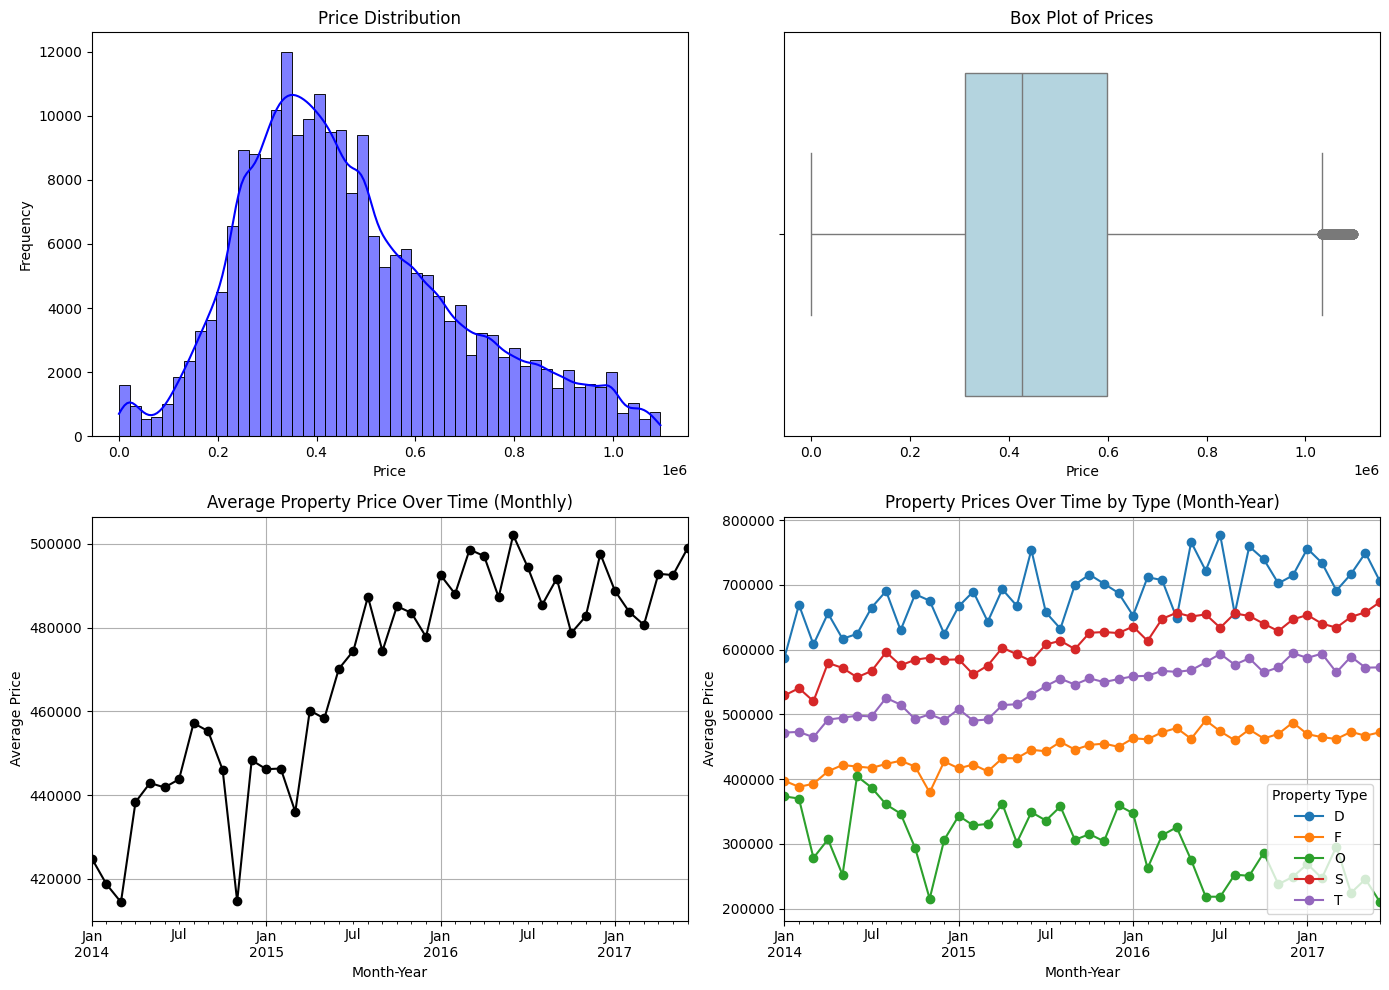

In [88]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Price Distribution (Histogram and KDE)
sns.histplot(data['Price'], kde=True, bins=50, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frequency')

# Plot 2: Box Plot to Detect Outliers
sns.boxplot(x=data['Price'], color='lightblue', ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Prices')
axes[0, 1].set_xlabel('Price')

# Plot 3: Time Series Analysis of Average Prices (Monthly)
data['Month-Year'] = data['Date of Transfer'].dt.to_period('M')  # Create Month-Year column

# Group by Month-Year and calculate the average price
avg_price_by_month = data.groupby('Month-Year')['Price'].mean()

# Plot the average price over time by month
avg_price_by_month.plot(kind='line', marker='o', color='black', ax=axes[1, 0])
axes[1, 0].set_title('Average Property Price Over Time (Monthly)')
axes[1, 0].set_xlabel('Month-Year')
axes[1, 0].set_ylabel('Average Price')
axes[1, 0].grid(True)

# Plot 4: Different Property Prices Over Time (Month-by-Month for Every Year)
# Group by Month-Year and Property Type to get the average price
avg_price_by_month_property_type = data.groupby(['Month-Year', 'Property Type'])['Price'].mean().unstack()

# Plot the average prices for each Property Type over each month of each year
avg_price_by_month_property_type.plot(kind='line', marker='o', ax=axes[1, 1])
axes[1, 1].set_title('Property Prices Over Time by Type (Month-Year)')
axes[1, 1].set_xlabel('Month-Year')
axes[1, 1].set_ylabel('Average Price')
axes[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


### What do they say:
plot1: 
plot2: 
plot3: 
plot4: 


## Cleansing Data
For creating the models we wil need to format and structurize our data correctly.

In [89]:
data.drop(columns=['Date of Transfer', 'Transaction unique identifier','Town/City', 'Record Status - monthly file only'], axis = 1, inplace = True)
data.head()

,Price,Property Type,Old/New,Duration,District,County,PPDCategory Type,Year,Month,Day,Month-Year
0,830000,D,N,F,BARNET,GREATER LONDON,A,2014,10,27,2014-10
1,800000,S,N,F,BARNET,GREATER LONDON,A,2014,12,22,2014-12
2,560500,T,N,F,BARNET,GREATER LONDON,A,2014,9,18,2014-09
4,682500,F,N,L,CITY OF WESTMINSTER,GREATER LONDON,A,2014,6,20,2014-06
5,360000,F,Y,L,GREENWICH,GREATER LONDON,A,2014,7,24,2014-07


In [90]:
# One-hot encode 'property_type' without dropping any category
data = pd.get_dummies(data, columns=['Property Type'], drop_first=False)

# Convert boolean columns (if they exist) to integers (1s and 0s)
property_type_columns = data.filter(like='Property Type_').columns
data[property_type_columns] = data[property_type_columns].astype(int)

# Drop irrelevant category 'Property Type_O'
if 'Property Type_O' in data.columns:
    data = data.drop(columns=['Property Type_O'])

# Verify columns
print(data.filter(like='Property Type_').head())



   Property Type_D  Property Type_F  Property Type_S  Property Type_T
0                1                0                0                0
1                0                0                1                0
2                0                0                0                1
4                0                1                0                0
5                0                1                0                0


In [91]:
# Filter columns starting with "Property Type_"
property_type_columns = data.filter(like='Property Type_')

# Count the number of entries for each property type (sum the True/1 values in each column)
property_type_counts = property_type_columns.sum()

# Display the counts
print(property_type_counts)

# Replace 'N' with 0 and 'Y' with 1 directly in the 'old/new' column
data['Old/New'] = data['Old/New'].replace({'N': 0, 'Y': 1})

# Replace 'F' with 0 and 'L' with 1 directly in the 'Duration' column
data['Duration'] = data['Duration'].replace({'F': 0, 'L': 1})

# Replace 'A' with 0 and '1' with 1 directly in the 'PPDCategory Type' column
data['PPDCategory Type'] = data['PPDCategory Type'].replace({'A': 0, 'B': 1})

# Check the updated DataFrame
data.head()

Property Type_D      1968
Property Type_F    156249
Property Type_S     11242
Property Type_T     45073
dtype: int64


,Price,Old/New,Duration,District,County,PPDCategory Type,Year,Month,Day,Month-Year,Property Type_D,Property Type_F,Property Type_S,Property Type_T
0,830000,0,0,BARNET,GREATER LONDON,0,2014,10,27,2014-10,1,0,0,0
1,800000,0,0,BARNET,GREATER LONDON,0,2014,12,22,2014-12,0,0,1,0
2,560500,0,0,BARNET,GREATER LONDON,0,2014,9,18,2014-09,0,0,0,1
4,682500,0,1,CITY OF WESTMINSTER,GREATER LONDON,0,2014,6,20,2014-06,0,1,0,0
5,360000,1,1,GREENWICH,GREATER LONDON,0,2014,7,24,2014-07,0,1,0,0


In [92]:
price_mean = data["Price"].mean()
price_median = data["Price"].median()

print('Mean:', price_mean)
print("Median:", price_median)

Mean: 467391.0389903894
Median: 426000.0


In [93]:
lin_df = data.copy()

lin_df['District'] = lin_df['District'].factorize()[0].astype('float32')
lin_df['County'] = lin_df['County'].factorize()[0].astype('float32')


lin_df

,Price,Old/New,Duration,District,County,PPDCategory Type,Year,Month,Day,Month-Year,Property Type_D,Property Type_F,Property Type_S,Property Type_T
0,830000,0,0,0.0,0.0,0,2014,10,27,2014-10,1,0,0,0
1,800000,0,0,0.0,0.0,0,2014,12,22,2014-12,0,0,1,0
2,560500,0,0,0.0,0.0,0,2014,9,18,2014-09,0,0,0,1
4,682500,0,1,1.0,0.0,0,2014,6,20,2014-06,0,1,0,0
5,360000,1,1,2.0,0.0,0,2014,7,24,2014-07,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252742,785000,0,1,22.0,0.0,0,2017,4,5,2017-04,0,1,0,0
252743,640000,0,1,19.0,0.0,0,2017,3,31,2017-03,0,1,0,0
252744,490000,0,1,22.0,0.0,0,2017,3,24,2017-03,0,1,0,0
252745,758000,0,0,6.0,0.0,0,2017,5,19,2017-05,0,0,0,1


In [94]:
feat_cols = ['District', 'County','Old/New', 'Duration', 'Year', 'Month', 'Property Type_D', 'Property Type_F', 'Property Type_S', 'Property Type_T'
             , 'PPDCategory Type']

In [95]:
X = lin_df[feat_cols]
y = lin_df['Price']

X['Year'] = X['Year'].astype(str).astype(int)
X['Year'].dtype

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_26580\2474983789.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



dtype('int32')

## Creating the Models
Models that will be created: Linear Regression & Decision Tree

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

In [97]:
scaler = StandardScaler()

normalized_array = scaler.fit_transform(X_train[feat_cols])
normalized_X_train = pd.DataFrame(normalized_array, columns=feat_cols)

normalized_X_train

,District,County,Old/New,Duration,Year,Month,Property Type_D,Property Type_F,Property Type_S,Property Type_T,PPDCategory Type
0,0.676462,-0.014782,2.369480,0.60021,0.854479,1.106308,-0.094638,0.642695,-0.232132,-0.506132,-0.389100
1,-1.039865,-0.014782,-0.422034,0.60021,0.854479,-0.642314,-0.094638,0.642695,-0.232132,-0.506132,-0.389100
2,-0.415746,-0.014782,-0.422034,0.60021,-0.169320,0.523434,-0.094638,0.642695,-0.232132,-0.506132,-0.389100
3,1.924699,-0.014782,-0.422034,0.60021,-0.169320,0.523434,-0.094638,0.642695,-0.232132,-0.506132,2.570034
4,1.144551,-0.014782,-0.422034,0.60021,-0.169320,0.814871,-0.094638,0.642695,-0.232132,-0.506132,2.570034
...,...,...,...,...,...,...,...,...,...,...,...
187673,0.208373,-0.014782,-0.422034,0.60021,0.854479,-0.933751,-0.094638,0.642695,-0.232132,-0.506132,-0.389100
187674,1.456610,-0.014782,-0.422034,0.60021,-0.169320,-1.225188,-0.094638,0.642695,-0.232132,-0.506132,-0.389100
187675,-1.507953,-0.014782,2.369480,0.60021,0.854479,-0.350877,-0.094638,0.642695,-0.232132,-0.506132,-0.389100
187676,1.144551,-0.014782,-0.422034,0.60021,-1.193120,-1.225188,-0.094638,0.642695,-0.232132,-0.506132,-0.389100


In [98]:
kf = KFold(n_splits = 5, random_state = None)

lreg = LinearRegression()
     
avg_lreg_score = cross_val_score(lreg , normalized_X_train, y_train, cv = kf)

In [99]:
# Train het lineaire regressiemodel
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print('Avg accuracy : {}'.format(avg_lreg_score))
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Avg accuracy : [0.12940979 0.13079592 0.13257652 0.1334729  0.13110621]
Mean Squared Error: 41585828504.44466
R² Score: 0.1328639761059035


Decision tree

In [100]:
kf = KFold(n_splits = 5, random_state = None)

tr_regressor = DecisionTreeRegressor(random_state = 42)

avg_tr_score = cross_val_score(tr_regressor, normalized_X_train, y_train, cv = kf)

In [101]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred_dt)
r2 = r2_score(y_test, y_pred_dt)

print('Avg accuracy : {}'.format(avg_tr_score))
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Avg accuracy : [0.35071016 0.347491   0.35968613 0.35763595 0.34885968]
Mean Squared Error: 30588292253.122665
R² Score: 0.36218151529075593


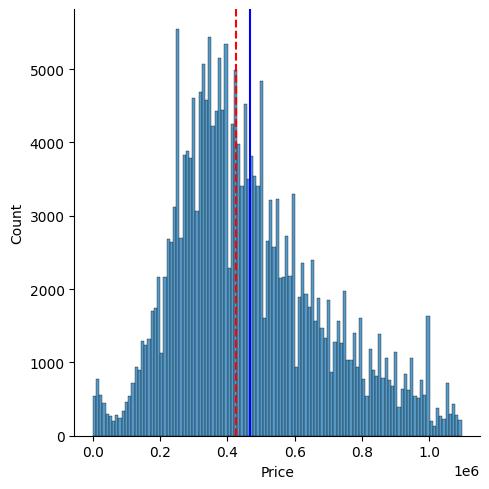

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

hp_mean = data["Price"].mean()
hp_median = data["Price"].median()

sns.displot(data = data, x = 'Price')
plt.axvline(x = hp_mean, color = 'Blue')
plt.axvline(x = hp_median, color = "Red", linestyle = '--')

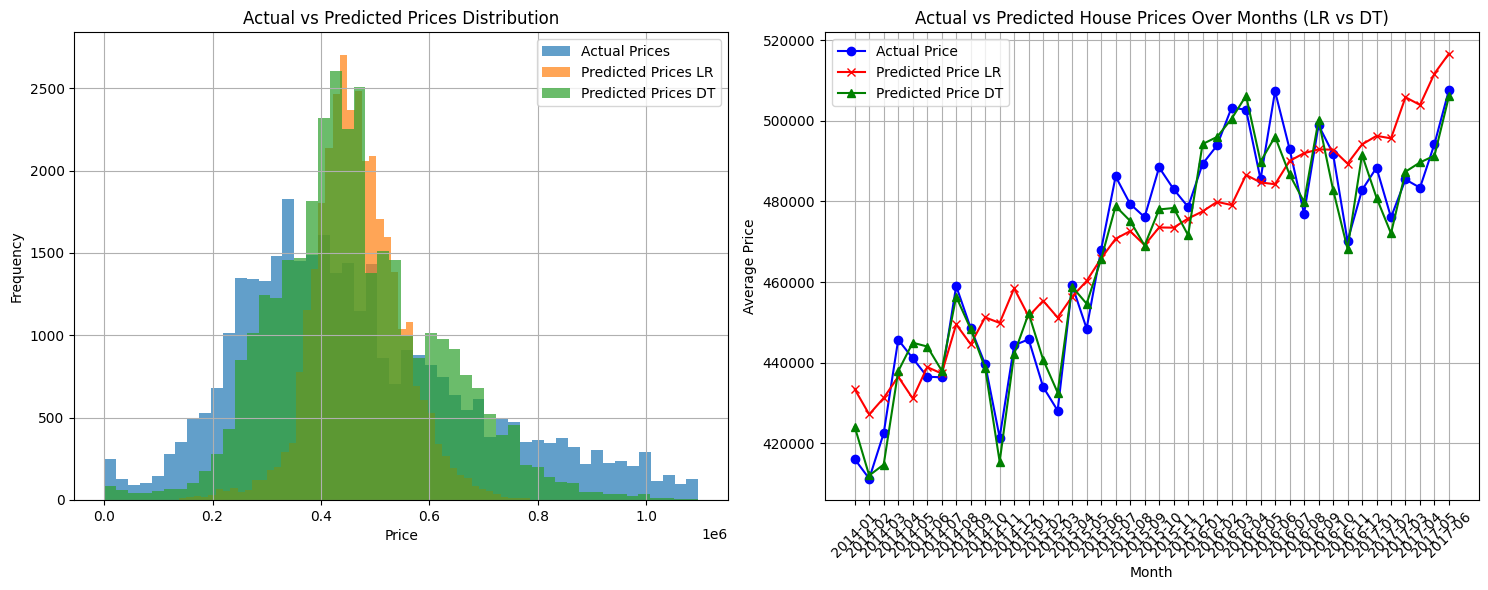

In [103]:
# Create a 1x2 subplot layout (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))  # Adjust figsize as needed

# Plot 1: Price Distribution (Histogram) with Actual and Predicted Prices (Linear Regression and Decision Tree)
ax[0].hist(y_test, bins=50, alpha=0.7, label='Actual Prices')
ax[0].hist(y_pred_lr, bins=50, alpha=0.7, label='Predicted Prices LR')
ax[0].hist(y_pred_dt, bins=50, alpha=0.7, label='Predicted Prices DT')
ax[0].legend(loc='upper right')
ax[0].set_title("Actual vs Predicted Prices Distribution")
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Frequency")
ax[0].grid(True)

# Create 'year_month' by formatting Year and Month as YYYY-MM
X_test['Year_Month'] = X_test['Year'].astype(str) + '-' + X_test['Month'].astype(str).str.zfill(2)

# Combine Actual and Predicted Prices with the Year_Month for Plot 2
result_df = pd.DataFrame({
    'Year_Month': X_test['Year_Month'],  # year_month as string format YYYY-MM
    'Actual Price': y_test,  # Actual prices
    'Predicted Price LR': y_pred_lr,  # Predicted prices from Linear Regression
    'Predicted Price DT': y_pred_dt  # Predicted prices from Decision Tree
})

# Group by Year_Month and calculate the average prices for plotting
result_df_grouped = result_df.groupby('Year_Month').agg({
    'Actual Price': 'mean',
    'Predicted Price LR': 'mean',
    'Predicted Price DT': 'mean'
}).reset_index()

# Plot 2: Actual vs Predicted House Prices Over Months (LR vs DT)
ax[1].plot(result_df_grouped['Year_Month'], result_df_grouped['Actual Price'], label='Actual Price', color='blue', marker='o')
ax[1].plot(result_df_grouped['Year_Month'], result_df_grouped['Predicted Price LR'], label='Predicted Price LR', color='red', marker='x')
ax[1].plot(result_df_grouped['Year_Month'], result_df_grouped['Predicted Price DT'], label='Predicted Price DT', color='green', marker='^')

# Adding titles and labels for Plot 2
ax[1].set_title('Actual vs Predicted House Prices Over Months (LR vs DT)')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Average Price')
ax[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better visibility
ax[1].legend()
ax[1].grid(True)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the combined plots
plt.show()
